In [164]:
import numpy as np
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, SpatialDropout1D, Input, TimeDistributed
from keras.losses import Huber, MeanSquaredError
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
plt.style.use('fivethirtyeight')

In [ ]:
#IHSG
stock_code = 'IHSG'
startdate = '2016-04-12'
enddate = '2021-04-12'
df = web.DataReader(f'^JKSE', data_source='yahoo', start = startdate, end = enddate)

In [2]:
#Ambil Data Saham
stock_code = 'UNVR'
#startdate = str((date.today()-timedelta(days = 365))) 
startdate = str((date.today()-relativedelta(years=5))) #Untuk ambil n tahun kebelakang dapat menggunakan relativedelta
enddate = str(date.today())
df = web.DataReader(f'{stock_code}.JK', data_source='yahoo', start = startdate, end = enddate)

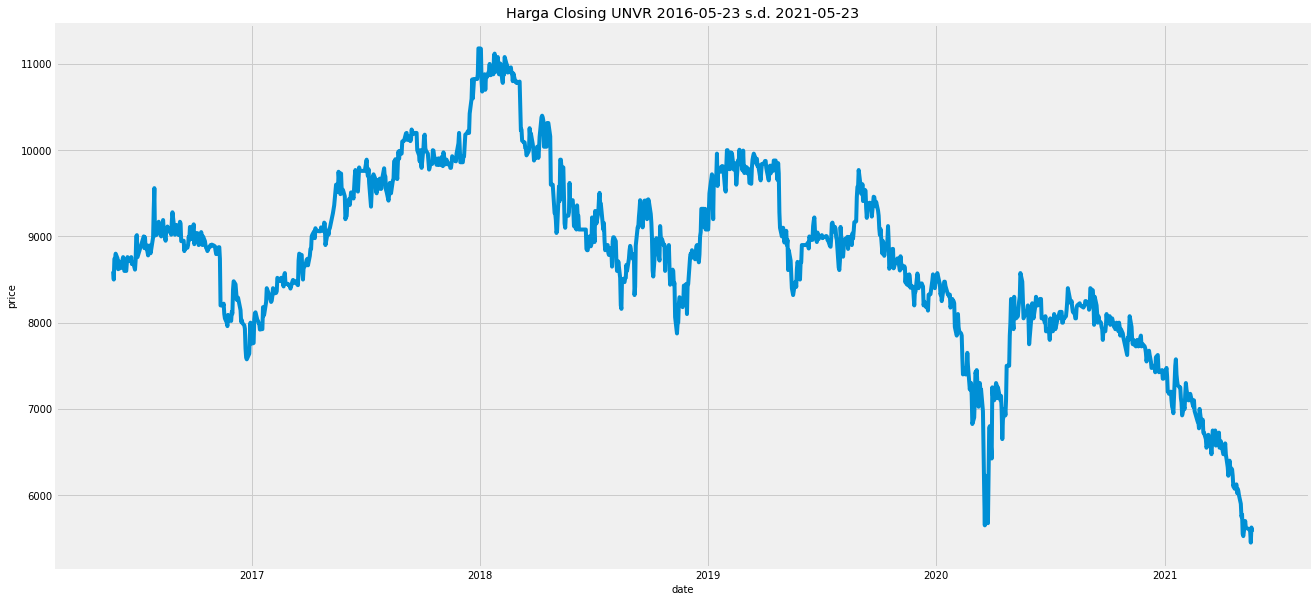

In [ ]:
plt.figure(figsize=(20,10))
plt.title(f'Harga Closing {stock_code} {startdate} s.d. {enddate}')
#plt.plot(df['Open'])
plt.plot(df['Close'])
plt.xlabel('date', fontsize = 10)
plt.ylabel('price', fontsize = 10)
plt.show()

In [137]:
#Ambil harga penutupan dari saham
data = df.filter(['Close'])
data["log_returns"] = np.log(1 + data['Close'].pct_change())
data.dropna(inplace=True)
dataset = data.values
data_len = len(dataset)
n_feature = dataset.shape[1]
print(data_len)

1259


In [138]:
data.head()

,Close,log_returns
Date,,
2016-05-24,8500.0,-0.011114
2016-05-25,8740.0,0.027844
2016-05-26,8735.0,-0.000572
2016-05-27,8800.0,0.007414
2016-05-30,8745.0,-0.006270


In [139]:
dataset

array([[ 8.50000000e+03, -1.11144753e-02],
       [ 8.74000000e+03,  2.78440262e-02],
       [ 8.73500000e+03, -5.72246081e-04],
       ...,
       [ 5.45000000e+03, -2.26767087e-02],
       [ 5.62500000e+03,  3.16053394e-02],
       [ 5.57500000e+03, -8.92863074e-03]])

In [ ]:
#embedding = LocallyLinearEmbedding(n_components=1)
#embedded_data = embedding.fit_transform(dataset)
#embedded_data.shape

(1260, 1)

In [140]:
#Apply MinMaxScaler / Normalisasi
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [142]:
scaled_data

array([[0.53228621, 0.24357708],
       [0.57417103, 0.40009179],
       [0.57329843, 0.28593019],
       ...,
       [0.        , 0.19712612],
       [0.03054101, 0.41520276],
       [0.02181501, 0.25235865]])

In [7]:
h = 360 #Jumlah test
inp = 14 #Besar input

In [143]:
data.iloc[0:data_len-h-inp,:]

,Close,log_returns
Date,,
2016-05-24,8500.0,-0.011114
2016-05-25,8740.0,0.027844
2016-05-26,8735.0,-0.000572
2016-05-27,8800.0,0.007414
2016-05-30,8745.0,-0.006270
...,...,...
2019-10-29,8715.0,0.001723
2019-10-30,8720.0,0.000574
2019-10-31,8745.0,0.002863


In [144]:
data.iloc[data_len-(inp+h):data_len,:]

,Close,log_returns
Date,,
2019-11-05,8770.0,0.018993
2019-11-06,8690.0,-0.009164
2019-11-07,8670.0,-0.002304
2019-11-08,8630.0,-0.004624
2019-11-11,8655.0,0.002893
...,...,...
2021-05-17,5600.0,-0.004454
2021-05-18,5575.0,-0.004474
2021-05-19,5450.0,-0.022677


In [145]:
train_data = scaled_data[0:data_len-h-inp,:] 
x_train = []
y_train = []
for i in range(inp, len(train_data)): 
  x_train.append(train_data[i-inp:i, :])
  y_train.append(train_data[i, :])
  #if i<=60:
  #  print(x_train)
  #  print(y_train)

In [146]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [147]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_feature)) 

In [166]:
learning_rate = 0.01
epoch=10

#model = Sequential()
input_model = Input(shape=(inp, n_feature))
lstm_model1 = LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], n_feature))
output1 = lstm_model1(input_model)
lstm_model2 = LSTM(100, return_sequences=False)
output2 = lstm_model2(output1)
dropout_layer = Dropout(0.4)
output3 = dropout_layer(output2)
dense_layer1 = Dense(32)
output4 = dense_layer1(output3)
dense_layer2 = Dense(2)
output_final = dense_layer2(output4)
model = Model(input_model,output_final)

In [167]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 14, 2)]           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 14, 100)           41200     
_________________________________________________________________
lstm_33 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 66        
Total params: 124,898
Trainable params: 124,898
Non-trainable params: 0
_____________________________________________________

In [ ]:
#model = load_model('StockPriceLSTMmodel.h5')

In [168]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate), loss = [Huber(), MeanSquaredError()])
model.fit(x_train, y_train, batch_size=10, epochs=epoch)

Epoch 1/10
88/88 [==============================] - 4s 12ms/step - loss: 0.0659
Epoch 2/10
88/88 [==============================] - 1s 12ms/step - loss: 0.0020
Epoch 3/10
88/88 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 4/10
88/88 [==============================] - 1s 12ms/step - loss: 0.0014
Epoch 5/10
88/88 [==============================] - 1s 12ms/step - loss: 0.0014
Epoch 6/10
88/88 [==============================] - 1s 12ms/step - loss: 0.0013
Epoch 7/10
88/88 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 8/10
88/88 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 9/10
88/88 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 10/10
88/88 [==============================] - 1s 12ms/step - loss: 0.0015


In [ ]:
#model.save('StockPriceLSTMmodel.h5')

In [151]:
test_data = scaled_data[data_len-(inp+h):data_len,:]
x_test = []
y_test = []
for i in range(inp, len(test_data)):
  x_test.append(test_data[i-inp:i, :])
  y_test.append(test_data[i, :])

In [152]:
x_test,y_test = np.array(x_test), np.array(y_test)

In [153]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_feature))

In [169]:
predictions = model.predict(x_test)
print('r2_score: ',r2_score(y_test[:,0], predictions[:,0]))
print('MAE: ', mean_absolute_error(y_test[:,0], predictions[:,0]))
print('MSE: ', mean_squared_error(y_test[:,0], predictions[:,0],squared=True))
print('rmse: ',mean_squared_error(y_test[:,0], predictions[:,0],squared=False))
predictions = scaler.inverse_transform(predictions)
#predictions[:,0]

r2_score:  0.9529180239863023
MAE:  0.019833626048066943
MSE:  0.0007962695532594574
rmse:  0.028218248585967512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


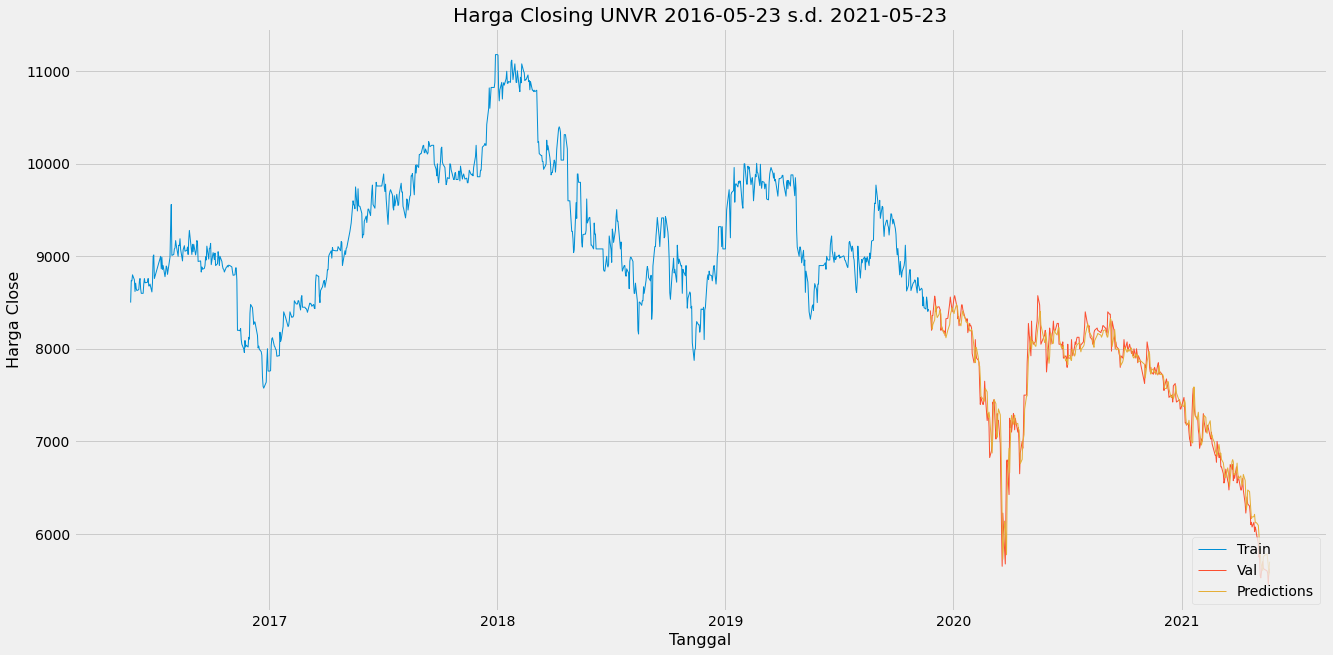

In [170]:
train = data[:data_len-h]
test = data[data_len-h:data_len]
test['Predictions'] = predictions[:,0]
plt.figure(figsize=(20,10))
plt.title(f'Harga Closing {stock_code} {startdate} s.d. {enddate}')
plt.xlabel('Tanggal', fontsize = 16 )
plt.ylabel('Harga Close', fontsize = 16 )
plt.plot(train['Close'],linewidth=1)
plt.plot(test[['Close','Predictions']],linewidth=1)
#x = pd.to_datetime('2018/02/01', format='%Y/%m/%d')
#str1 = 'Learning rate: {}'.format(learning_rate)
#str2 = 'Epoch: {}'.format(epoch)
#plt.annotate(str1, (x,4200), (x,4200), fontsize=12)
#plt.annotate(str2, (x,4100), (x,4100), fontsize=12)
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

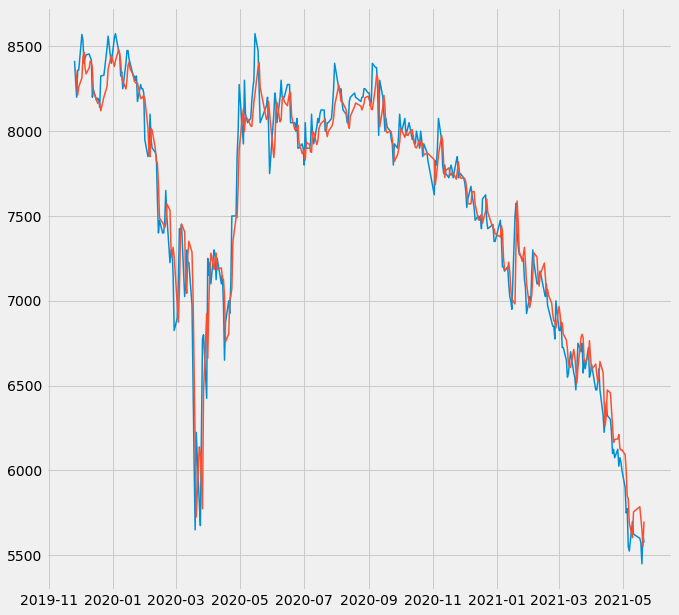

In [171]:
plt.figure(figsize=(10,10))
plt.plot(test[['Close','Predictions']],linewidth=1.5)

Prediksi Untuk Hari-hari Kedepan

In [159]:
inp

14

In [172]:
hari = int(input("Jumlah hari: "))
data_pred = scaled_data[data_len-inp:data_len,:]
for i in range(0,hari):
  x_pred = np.vstack(data_pred[i:i+inp, :])
  x_pred = np.array(x_pred)
  x_pred = np.reshape(x_pred, (1, x_pred.shape[0], n_feature))
  predict = model.predict(x_pred)
  data_pred = np.vstack((data_pred, predict))

Jumlah hari: 30


[[5.76142176e+03 1.31758593e-02]
 [5.81335500e+03 1.17977623e-02]
 [5.88383998e+03 1.11536272e-02]
 [5.97049149e+03 1.08037711e-02]
 [6.05699641e+03 1.03512327e-02]
 [6.13627731e+03 9.90944315e-03]
 [6.20833509e+03 9.51137637e-03]
 [6.27888257e+03 9.21888508e-03]
 [6.34701684e+03 8.98594691e-03]
 [6.40823624e+03 8.70061416e-03]
 [6.46416065e+03 8.44721665e-03]
 [6.51599237e+03 8.24573156e-03]
 [6.56429920e+03 8.05193169e-03]
 [6.61188761e+03 7.92209876e-03]
 [6.65523920e+03 7.75909916e-03]
 [6.69686193e+03 7.61610638e-03]
 [6.73606114e+03 7.48174837e-03]
 [6.77309178e+03 7.35127747e-03]
 [6.80808593e+03 7.22566548e-03]
 [6.84119813e+03 7.10655182e-03]
 [6.87259703e+03 6.99388455e-03]
 [6.90241744e+03 6.88658804e-03]
 [6.93075799e+03 6.78386113e-03]
 [6.95770217e+03 6.68552578e-03]
 [6.98333434e+03 6.59147813e-03]
 [7.00773869e+03 6.50147340e-03]
 [7.03099242e+03 6.41532611e-03]
 [7.05316638e+03 6.33282115e-03]
 [7.07432599e+03 6.25380273e-03]
 [7.09453049e+03 6.17813732e-03]]


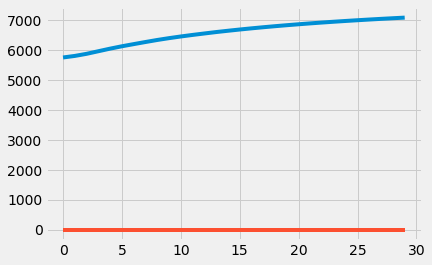

In [173]:
hasil_prediksi = data_pred[len(data_pred)-hari:len(data_pred),:]
hasil_prediksi = scaler.inverse_transform(hasil_prediksi)
print(hasil_prediksi) #Hasil prediksi
plt.plot(hasil_prediksi)